# Assignment 3: Data Estimation
### Dhruv Prasad, EE23B130

Planck's law describes the spectral radiance of electromagnetic radiation emitted by a black body in thermal equilibrium at a given temperature **T**. The formula is:

$$
S(\lambda, T) = \frac{2hc^2}{\lambda^5} \cdot \frac{1}{\exp\left(\frac{hc}{\lambda k_B T}\right) - 1}
$$

Where:
- $ S(\lambda, T) $ is the spectral radiance (the power emitted per unit area, per unit solid angle, per unit wavelength).
- $ \lambda $ is the wavelength of the radiation.
- $ T $ is the absolute temperature of the black body in kelvins.
- $ h $ is Planck's constant $(6.626 \times 10^{-34} \, \text{Js})$.
- $ c $ is the speed of light in a vacuum $(3.0 \times 10^8 \, \text{m/s})$.
- $ k_B $ is the Boltzmann constant $(1.38 \times 10^{-23} \, \text{J/K})$.

The objective of this assignment is to take the constants as unknown parameters and optimize them, given a dataset of spectral radiance and wavelength values.


In [81]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from typing import List, Callable, Tuple

# To show interactive plots in jupyter notebooks
%matplotlib ipympl

Here, I have made a class `Data` to hold all data related to a given file so that I can perform certain operations easily over a list of different files.

It expects a file containing x and y coordinates data separated by commas.

It stores these values when intitialized with a file.

Once `fit()` is called on an instance of `Data` with a model function and a List of initial guesses for unknown parameters of the model function, it estimates those parameters and stores them.

We can plot the fitted curve along with the raw data using `plot_data_and_fitted_curve()`. It has parameters to customize the plot.

*Note: `plot_data_and_fitted_curve()` must be called only once `fit()` has been called*

*Note: The reason behind requiring initial guesses is that if data ranges from highly negative to highly positive powers of 10, the calculations can easily cause overflows without a good initial guess with atleast the orders of magnitude correct*

In [82]:
# Define a class Data with an initializer
class Data:
    ''' Holds all data related to a given file \n
    '''
    def __init__(self, filename: str):
        '''When initialized with a file name, loads a 2D numpy array with co-ordinates \n
        Creates two numpy arrays to hold x and y values separately \n
        '''
        self.points = np.loadtxt(filename, float, delimiter=',') # Loads coordinates as 2-D numpy array
        self.x_values = self.points[:, 0]  # All rows, first column (x values)
        self.y_values = self.points[:, 1]  # All rows, second column (y values)
    
    def fit(self, function: Callable, initial_guesses: List):
        '''Fits curve for a model function and a List containing initial guesses \n
        Returns optimized parameters (Array)\n
        '''
        # This function must take x_values as first argument
        self.model_function = function

        # Using curve_fit() function from scipy.optimize
        self.popt, self.pcov = curve_fit(function, self.x_values, self.y_values, p0=initial_guesses)

        # popt is in the order of next parameters of function
        return self.popt
    
    def plot_data_and_fitted_curve(self, curve_color: str, data_color: str, x_label: str, y_label: str):
        '''Plots the fitted curve along with the raw data \n
        Returns optimized parameters (Array) and their covariance matrix (2D Array)\n
        '''
        # Begin plotting
        plt.figure()

        # Plot the original data
        plt.plot(self.x_values, self.y_values, label='Data', color=data_color)

        # Plot fitted curve using optimized parameters
        self.new_y_values = self.model_function(self.x_values, *self.popt)
        plt.plot(self.x_values, self.new_y_values, label='Fitted Radiance', color=curve_color)

        # Add labels and a legend
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()

        # Show the plot
        plt.show()

Below I have defined a function for spectral radiance that takes in wavelength and other parameters too as arguments, and tried to find the optimized parameters.

In [83]:
def radiance(wavelength: float, h: float, c: float, kb: float, T: float)-> float:
    '''Function that calculates spectral radiance for a given wavelength, \n
    Parameters: Wavelength, Planck's constant h, Speed of light c, Boltzmann's constant kb, Temperature T
    '''
    return (2*h*c*c) / ((wavelength**5) * (np.exp((h*c)/(wavelength*kb*T)) - 1))

In [84]:
# List of all files available to test on
all_files = ["d1.txt", "d2.txt", "d3.txt", "d4.txt"]

# Initialize a List containing `Data` for each file
all_files_data: List[Data] = []
for file in all_files:
    all_files_data.append(Data(file))

[2.05490314e-33 1.67939365e+08 8.28448143e-24 1.17021998e+04]


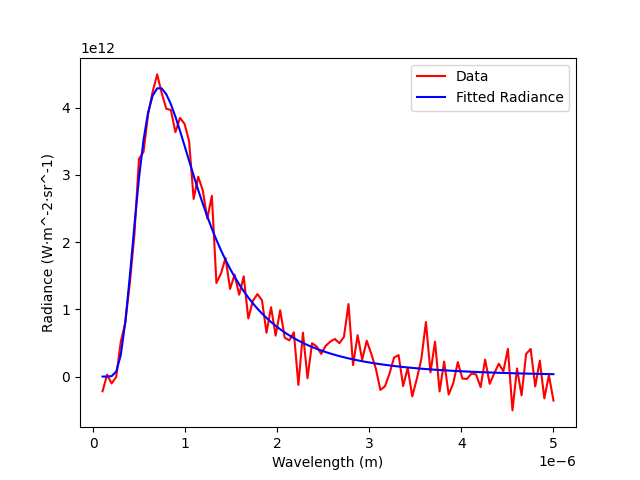

[6.91645380e-34 2.36040638e+08 1.35537293e-23 3.60804699e+03]


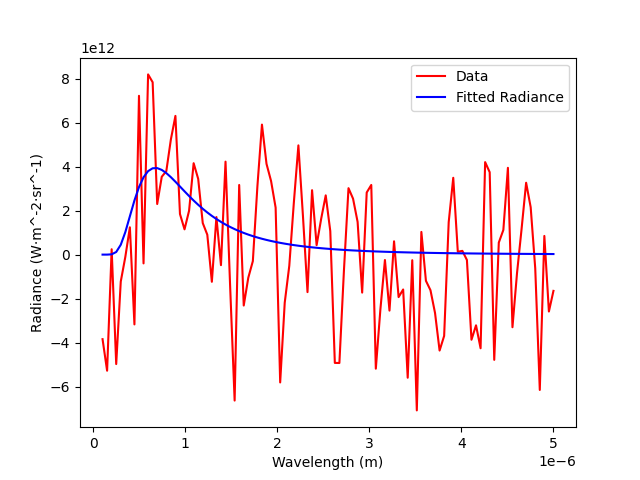

[2.72649126e-33 1.43974611e+08 1.55996768e-23 7.07103880e+03]


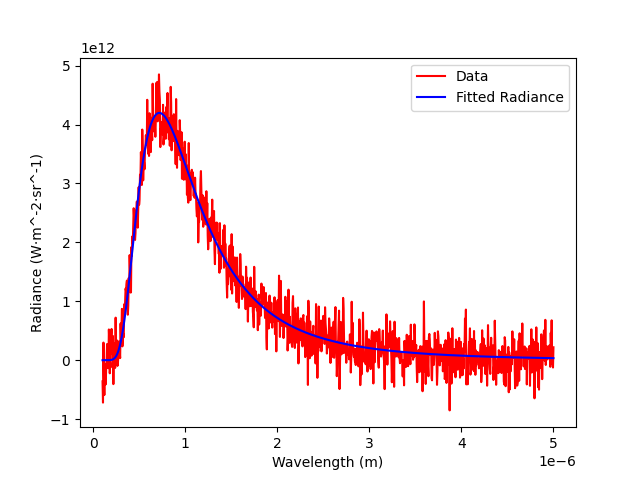

[1.90031348e-33 1.72176974e+08 1.35179393e-23 6.64314237e+03]


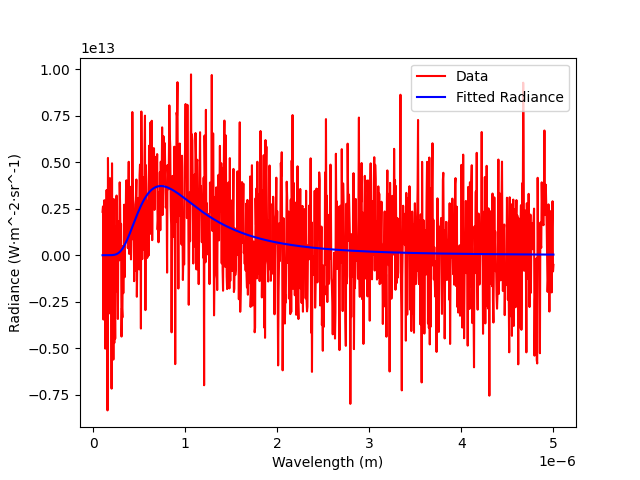

In [85]:
# Reasonable initial guess
p0 = [6e-34, 3e8, 2e-23, 6e3]

# Print the optimized parameters and plot the fitted curve for each file
for file_data in all_files_data:
    print(file_data.fit(radiance, p0))
    file_data.plot_data_and_fitted_curve('blue', 'red', 'Wavelength (m)', 'Radiance (W·m^-2·sr^-1)')

### Partial Application

As we can see, though the above plots are reasonable, the estimated parameters are way off. This is because of the noisy data, and also the fact that some parameters can't be separated.  
For eg: kb and T appear only as a product in the formula so even if we can predict their product, we can never get their values separately.  
The only reason we didn't get completely random values were because of the initial guesses being quite accurate.

In planck's formula, $h, c, kb$ are physical constants that can be determined by other methods and it is often so in reality. So we can assume correct values of some of them and make simpler functions with fewer unknowns and try to predict it. This is called partial application.

Below, I have tried to find the value of planck's constant $h$ by taking only $T$ and $h$ as parameters along with variable wavelength. The same has been done for speed of light $c$ also.

In [86]:
# Partial application functions
def partial_radiance_for_h_and_c(wavelength, h, c):
    return radiance(wavelength=wavelength, h=h, c=c, kb=1.38e-23, T=3.8e3)

def partial_radiance_for_c(wavelength, c, T):
    return radiance(wavelength=wavelength, h=6.626e-34, c=c, kb=1.38e-23, T=T)

In [87]:
# Initial guesses that are slightly more innacurate
initial_guess_for_h_and_c = [6e-34, 3e8]
initial_guess_for_c = [1e8, 4e3]

# Print optimized parameters
print("Predicted h and c values: ")
for file_data in all_files_data:
    print(file_data.fit(partial_radiance_for_h_and_c, initial_guess_for_h_and_c))

print("Predicted c values and T: ")
for file_data in all_files_data:
    print(file_data.fit(partial_radiance_for_c, initial_guess_for_c))

Predicted h and c values: 
[6.01244342e-34 3.10472176e+08]
[7.95319063e-34 2.20120339e+08]
[6.16213651e-34 3.02846270e+08]
[6.47989551e-34 2.94858837e+08]
Predicted c values and T: 
[2.95748447e+08 3.98918165e+03]
[2.41167850e+08 3.46853837e+03]
[2.92053337e+08 3.94043036e+03]
[2.91588577e+08 3.84259170e+03]


As we can see, the predicted values of $h$ and $c$ are quite accurate and have less than 10% error in all but one case despite the initial guesses being a lot more inaccurate.  
Only for the second file, the data is too noisy and the error in $h$ and $c$ is coming out to be 35.4% and 19.6%.  
The temperature has also changed from the initial guess and in those cases where $h$ and $c$ are accurate we can assume that the predicted T would be close to the actual temperature at which the data was measured.

Hence, we conclude that by using partial application, we can predict upto 2 unknown parameters reliably in a function provided they can be separated.

Just for visualizing purposes, I have provided code to plot the graphs of above predictions below. You have to uncomment and run it.

In [88]:
# Plot graphs fitted with the partial application functions

# print("Predicted h values and T: ")
# for file_data in all_files_data:
#     print(file_data.fit(partial_radiance_for_h, initial_guess_for_h))
#     file_data.plot_data_and_fitted_curve('blue', 'red', 'Wavelength (m)', 'Radiance (W·m^-2·sr^-1)')

# print("Predicted c values and T: ")
# for file_data in all_files_data:
#     print(file_data.fit(partial_radiance_for_c, initial_guess_for_c))
#     file_data.plot_data_and_fitted_curve('blue', 'red', 'Wavelength (m)', 'Radiance (W·m^-2·sr^-1)')
